<a href="https://colab.research.google.com/github/HwangHanJae/ml-definitive-guide-pratice/blob/main/evaluation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

분류의 평가방법(분류에 사용되는 평가지표)
- 정확도(Accuracy)
- 오차행렬(Confusion Matrix)
- 정밀도(Precision)
- 재현율(Recall)
- F1 스코어
- ROC AUC

6개의 지표모두 이진 분류에서 더욱 중요하게 강조하는 지표

정확도

= 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수

In [4]:
#정확도만 사용하면 안되는 경우
from sklearn.base import BaseEstimator
import numpy as np
class MyDummyClassifier(BaseEstimator):
  #fit() 메서드는 아무것도 학습하지 않음
  def fit(self, X, y=None):
    pass
  #predict 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
  def predict(self, X):
    pred = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
      if X["Sex"].iloc[i] == 1:
        pred[i] =0
      else:
        pred[i] = 1
    return pred

In [2]:
#위에서 했던 작업들을 수행하기 편하게 함수로 정리

#Null(결측값)처리
def fillna(df):
  df["Age"] = df["Age"].fillna(df["Age"].mean())
  df["Cabin"] = df['Cabin'].fillna("N")
  df["Embarked"] = df["Embarked"].fillna("N")
  df["Fare"] = df["Fare"].fillna(0)

  return df

#불필요한 속성 제거
def drop_features(df):
  drop_col = ["PassengerId", "Name", "Ticket"]
  df.drop(drop_col, axis=1, inplace = True)
  return df

#LabelEncoding 수행

def format_features(df):
  from sklearn.preprocessing import LabelEncoder
  df["Cabin"] = df["Cabin"].str[:1]
  features = ["Cabin", "Sex","Embarked"]
  for feature in features:
    encoder = LabelEncoder()
    encoder.fit(df[feature])
    df[feature] = encoder.transform(df[feature])
  return df

#위에서 작성한 함수를 실행하는 함수
def transform_features(df):
  fillna(df)
  drop_features(df)
  format_features(df)
  return df

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#원본 데이터 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
train_path = "/content/drive/MyDrive/Colab Notebooks/DataScience/Data/titanic/train.csv"

titanic_df = pd.read_csv(train_path)
y = titanic_df["Survived"]
X = titanic_df.drop("Survived", axis=1)
X = transform_features(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

#위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행

myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)
my_pred = myclf.predict(X_test)
print("Dummy Classifier의 정확도 : {}".format(accuracy_score(y_test, my_pred).round(4)))

Dummy Classifier의 정확도 : 0.7877


단순한 알고리즘으로 예측을 하더라도 데이터의 구성에 따라 정확도가 약 78.77%로 높은 수치가 나올 수 있기 때문에 신중하게 사용해야 함

정확도는 불균형한 레이블 값 분포의 모델의 성능을 판단할 경우 적합한 평가지표가 아님

In [11]:
#불균형한 레이블 값의 분포 예제
#레이블의 값이 7인 것만 True, 나머지 값은 False
#전체 데이터의 10%만 True, 나머지 90%는 False로 변형
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
  def fit(self, X, y):
    pass
  
  #입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 변환
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)
  
#사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

#digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환

y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

#불균형한 데이터로 생성한 y_test의 데이터 분포도 확인
print("레이블 테스트 데이터 크기 : ", y_test.shape)
print("테스트 세트 레이블 0 과 1의 분포도")
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습/예측/평가
clf = MyFakeClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f"모든 예측을 0으로 하여도 정확도는 : {(accuracy_score(y_test, pred))}")


레이블 테스트 데이터 크기 :  (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는 : 0.9


**오차행렬(Confusion matrix)**

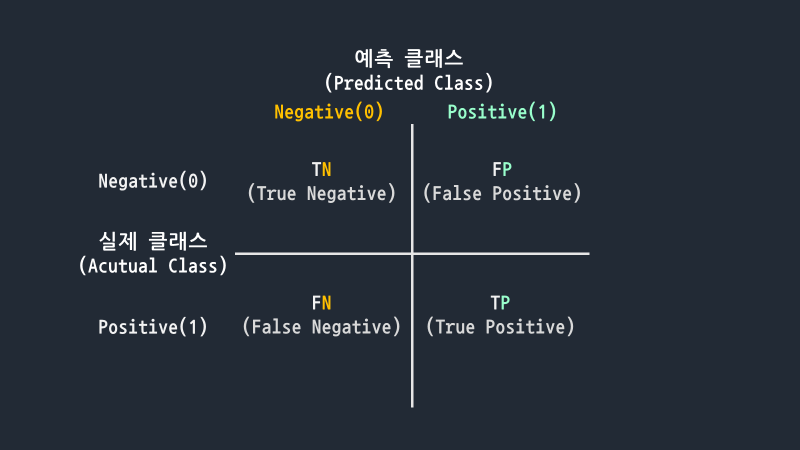

TN : 예측 값은 Negative(0)로 예측 했고, 실제 값 역시 Negative(0)

FP : 예측 값은 Positive(1)로 예측 했고, 실제 값은 Negative(0)

FN : 예측 값은 Negative(0)로 예측 했고, 실제 값은 Positive(1)

TP : 예측 값은 Positive(1)로 예측 했고, 실제 값은 Positive(1)


In [20]:
#위에서의 예제를 confusion matrix로 평가
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, pred))
print(np.array([["TN","FP"],
       ["FN", "TP"]]))

[[405   0]
 [ 45   0]]
[['TN' 'FP']
 ['FN' 'TP']]


confusion_matrix로 정확도, 정밀도, 재현율을 알 수 있음



0.9